## Stochastic OnsagerNet with Constant Diagonal diffusion matrix for DNA trajectory prediction

In [1]:
import os
import sys

# # Set GPU or CPU; -1: CPU
# 0, 1, 2, 3: GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# disable message output from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
sys.path.append("../src")
sys.path.append("../src/onetlib")

In [3]:
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from lorenz_data.data_generator import data_generator_sde
from lorenz_data.data_generator import euler_sde
from lorenz_data.data_generator import euler_sde_net
from lorenz_data.data_generator import euler
import onsagernet as onet
from scipy import stats

In [4]:
tf.random.set_seed(1)

## Load data

The DNA data is 3-dimensional. For convenience, we denote the first, second and the third dimension by $X$,$Y$ and $Z$. We have $610$ DNA trajectories for training and $110$ DNA trajectories for testing. Each trajectory has length 1001, and the time step between the neighboring point is $\frac{0.5}{1000}$ . 

In [5]:
with open('DNA_data/DNA_data_resnet.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
X1_train = data['X1_train']
X2_train = data['X2_train']
X3_train = data['X3_train']

X1_test = data['X1_test']
X2_test = data['X2_test']
X3_test = data['X3_test']

X1_fast_test = data['X1_fast_test']
X2_fast_test = data['X2_fast_test']
X3_fast_test = data['X3_fast_test']

X1_slow_test = data['X1_slow_test']
X2_slow_test = data['X2_slow_test']
X3_slow_test = data['X3_slow_test']

X1_fast_slow_test = data['X1_fast_slow_test']
X2_fast_slow_test = data['X2_fast_slow_test']
X3_fast_slow_test = data['X3_fast_slow_test']

print('X1_train shape:{}'.format(X1_train.shape))
print('X1_test shape:{}'.format(X1_test.shape))
print('X1_fast shape:{}'.format(X1_fast_test.shape))
print('X1_slow shape:{}'.format(X1_slow_test.shape))
print('X1_fast_slow shape:{}'.format(X1_fast_slow_test.shape))

X1_train shape:(610, 1001)
X1_test shape:(110, 1001)
X1_fast shape:(500, 1001)
X1_slow shape:(200, 1001)
X1_fast_slow shape:(500, 1001)


In [7]:
X1_train = tf.reshape(X1_train,shape = (610,1001,1))
X2_train = tf.reshape(X2_train,shape = (610,1001,1))
X3_train = tf.reshape(X3_train,shape = (610,1001,1))
X1_test = tf.reshape(X1_test,shape = (110,1001,1))
X2_test = tf.reshape(X2_test,shape = (110,1001,1))
X3_test = tf.reshape(X3_test,shape = (110,1001,1))

We choose the time step between the input variables and output variabels to be $\frac{0.5}{1000} \times 5$ .

In [8]:
step = 5
X_train = tf.concat([X1_train[:,:1001-step,:],X2_train[:,:1001-step,:],X3_train[:,:1001-step,:]],-1)
X_train = tf.reshape(X_train,shape = (-1,3))
X_train = tf.cast(X_train,tf.float64)
X_train.shape

TensorShape([607560, 3])

In [9]:
Y_train = tf.concat([X1_train[:,step:,:],X2_train[:,step:,:],X3_train[:,step:,:]],-1)
Y_train = tf.reshape(Y_train,shape = (-1,3))
Y_train = tf.cast(Y_train,tf.float64)
Y_train.shape

TensorShape([607560, 3])

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train.numpy(), Y_train.numpy(), test_size=0.2)

In [11]:
print('X_train shape:{}'.format(X_train.shape))
print('Y_train shape:{}'.format(Y_train.shape))
print('X_val shape:{}'.format(X_val.shape))
print('Y_val shape:{}'.format(Y_val.shape))

X_train shape:(486048, 3)
Y_train shape:(486048, 3)
X_val shape:(121512, 3)
Y_val shape:(121512, 3)


In [12]:
X_train = tf.constant(X_train)
X_val = tf.constant(X_val)
Y_train = tf.constant(Y_train)
Y_val = tf.constant(Y_val)

## Build OnsagerNet SDE model

In [13]:
beta = 0.1
alpha = 0.01
n_features = 3
delta_t = 0.5/1000 * step

pot_layer_size = [128,50]
dc_layer_sizes = [20,20]
fc_layer_sizes = []
diffu_layer_sizes = []

In [14]:
# build Onsager net 
def build_onsager_net():
    # choose the activation function of FCPotentialNet to be tanh
    # tanh activation functiong works better on the DNA demo
    potential_net = onet.FCPotentialNet(beta = beta,
                                       layer_sizes = pot_layer_size,
                                       n_pot = n_features)
    dissconv_net = onet.FCDissConsNet(n_dim = n_features,
                                     layer_sizes = dc_layer_sizes)
    forcing_net = onet.ZeroForcingNet(n_dim = n_features)
    onsager_net = onet.OnsagerNet(n_dim = n_features,
                                  potential_net = potential_net,
                                  dissconv_net = dissconv_net,
                                  forcing_net = forcing_net,
                                  alpha = alpha)
    
    DiffusitivityNet = onet.DiffusitivityNet(n_dim = n_features,layer_sizes = diffu_layer_sizes,mode = 'constant_diagonal')
    
    inputs = tf.keras.Input((n_features,))
    outputs = tf.concat([inputs,onsager_net(inputs),DiffusitivityNet(inputs)],1)
    OnsagerNet = tf.keras.Model(inputs,outputs,name = 'onsager_rhs')
    return OnsagerNet

In [15]:
model = onet.SDEOnsagerNet(n_features = n_features,delta_t = delta_t, OnsagerNet = build_onsager_net())
model.build(input_shape = (None,n_features))
model.summary()

Model: "sde_onsager_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 onsager_rhs (Functional)    (None, 15)                7807      
                                                                 
Total params: 7,807
Trainable params: 7,807
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), loss = onet.CustomEulerLoss(epsilon = 1e-4,n_features = n_features,delta_t = delta_t))

In [17]:
model.evaluate(X_train,Y_train)

15189/15189 [==============================] - 23s 1ms/step - loss: 78.0188


78.018798828125

In [18]:
# set learning rate
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.4, patience = 3 , min_lr = 1e-8)
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_val,Y_val),
                    batch_size= 256,
                    epochs = 40,
                    callbacks = lr)

Epoch 1/40
1899/1899 [==============================] - 12s 5ms/step - loss: -9.2348 - val_loss: -10.5672 - lr: 0.0100
Epoch 2/40
1899/1899 [==============================] - 10s 5ms/step - loss: -10.6102 - val_loss: -10.6067 - lr: 0.0100
Epoch 3/40
1899/1899 [==============================] - 11s 6ms/step - loss: -10.6184 - val_loss: -10.6050 - lr: 0.0100
Epoch 4/40
1899/1899 [==============================] - 11s 6ms/step - loss: -10.8186 - val_loss: -11.5558 - lr: 0.0100
Epoch 5/40
1899/1899 [==============================] - 10s 6ms/step - loss: 50.6757 - val_loss: -9.2496 - lr: 0.0100
Epoch 6/40
1899/1899 [==============================] - 11s 6ms/step - loss: -9.4236 - val_loss: -9.5624 - lr: 0.0100
Epoch 7/40
1899/1899 [==============================] - 11s 6ms/step - loss: -9.6574 - val_loss: -9.7590 - lr: 0.0100
Epoch 8/40
1899/1899 [==============================] - 10s 5ms/step - loss: -9.8413 - val_loss: -9.9199 - lr: 0.0040
Epoch 9/40
1899/1899 [===========================

In [19]:
history = model.fit(x = X_train,
                    y = Y_train,
                    validation_data = (X_val,Y_val),
                    batch_size= 256,
                    epochs = 20,
                    callbacks = lr)

Epoch 1/20
1899/1899 [==============================] - 11s 6ms/step - loss: -12.2853 - val_loss: -12.2937 - lr: 2.5600e-04
Epoch 2/20
1899/1899 [==============================] - 11s 6ms/step - loss: -12.2853 - val_loss: -12.2910 - lr: 2.5600e-04
Epoch 3/20
1899/1899 [==============================] - 11s 6ms/step - loss: -12.2861 - val_loss: -12.2916 - lr: 2.5600e-04
Epoch 4/20
1899/1899 [==============================] - 11s 6ms/step - loss: -12.2859 - val_loss: -12.2893 - lr: 2.5600e-04
Epoch 5/20
1899/1899 [==============================] - 11s 6ms/step - loss: -12.2891 - val_loss: -12.2955 - lr: 1.0240e-04
Epoch 6/20
1899/1899 [==============================] - 10s 5ms/step - loss: -12.2895 - val_loss: -12.2934 - lr: 1.0240e-04
Epoch 7/20
1899/1899 [==============================] - 10s 5ms/step - loss: -12.2895 - val_loss: -12.2949 - lr: 1.0240e-04
Epoch 8/20
1899/1899 [==============================] - 11s 6ms/step - loss: -12.2898 - val_loss: -12.2940 - lr: 1.0240e-04
Epoch 9/

We choose 3 different initial conditions such that chains generally stretch at different rates from each condition. We denote the 3 condistions by fast, fast_slow and slow. We simulate the learned stochastic OnsagerNet model 500 times and obtain the predicted trajectoried. We also compared the predicted mean and covariance of the stretching trajectories with the true mean and covariance. 

The picture below is a reproduction of Figure 3 of the paper '(remained to complete)'. 

In [20]:
Z_std = 69.79624239435213
Z_mean = 208.21994500581388

In [21]:
# fast
X1_fast_test = X1_fast_test.reshape((-1,1001,1))
X2_fast_test = X2_fast_test.reshape((-1,1001,1))
X3_fast_test = X3_fast_test.reshape((-1,1001,1))

trajectory_true_fast= tf.concat([X1_fast_test,X2_fast_test,X3_fast_test],-1)
trajectory_true_fast= tf.cast(trajectory_true_fast,tf.float64)
trajectory_initial_fast = trajectory_true_fast[:,0,:]

In [22]:
## fast
trajectory_pred_fast = np.zeros(trajectory_true_fast.shape)
trajectory_pred_fast[:,0,:] = trajectory_initial_fast

# 1000-step prediction
for i in range(1000):
    trajectory_pred_fast[:,i+1,:] = model.predict(trajectory_pred_fast[:,i,:],dt = 0.5/1000)
    

In [23]:
trajectory_true_fast = trajectory_true_fast*Z_std+Z_mean
trajectory_pred_fast = trajectory_pred_fast*Z_std+Z_mean

true_mean_fast = np.mean(trajectory_true_fast,axis = 0)
pred_mean_fast = np.mean(trajectory_pred_fast,axis = 0)
true_cov_fast = np.cov(tf.transpose(trajectory_true_fast[:,:,0]))
pred_cov_fast = np.cov(tf.transpose(trajectory_pred_fast[:,:,0]))

In [24]:
# slow
X1_slow_test = X1_slow_test.reshape((-1,1001,1))
X2_slow_test = X2_slow_test.reshape((-1,1001,1))
X3_slow_test = X3_slow_test.reshape((-1,1001,1))

trajectory_true_slow= tf.concat([X1_slow_test,X2_slow_test,X3_slow_test],-1)
trajectory_true_slow= tf.cast(trajectory_true_slow,tf.float64)
trajectory_initial_slow = trajectory_true_slow[:,0,:]

In [25]:
## slow
trajectory_pred_slow = np.zeros(trajectory_true_slow.shape)
trajectory_pred_slow[:,0,:] = trajectory_initial_slow

# 1000-step prediction
for i in range(1000):
    trajectory_pred_slow[:,i+1,:] = model.predict(trajectory_pred_slow[:,i,:],dt = 0.5/1000)
    

In [26]:
trajectory_true_slow = trajectory_true_slow*Z_std+Z_mean
trajectory_pred_slow = trajectory_pred_slow*Z_std+Z_mean
true_mean_slow = np.mean(trajectory_true_slow,axis = 0)
pred_mean_slow = np.mean(trajectory_pred_slow,axis = 0)
true_cov_slow = np.cov(tf.transpose(trajectory_true_slow[:,:,0]))
pred_cov_slow = np.cov(tf.transpose(trajectory_pred_slow[:,:,0]))


In [27]:
# fast_slow
X1_fast_slow_test = X1_fast_slow_test.reshape((-1,1001,1))
X2_fast_slow_test = X2_fast_slow_test.reshape((-1,1001,1))
X3_fast_slow_test = X3_fast_slow_test.reshape((-1,1001,1))

trajectory_true_fast_slow= tf.concat([X1_fast_slow_test,X2_fast_slow_test,X3_fast_slow_test],-1)
trajectory_true_fast_slow= tf.cast(trajectory_true_fast_slow,tf.float64)
trajectory_initial_fast_slow = trajectory_true_fast_slow[:,0,:]

In [28]:
## fast_slow
trajectory_pred_fast_slow = np.zeros(trajectory_true_fast_slow.shape)
trajectory_pred_fast_slow[:,0,:] = trajectory_initial_fast_slow


# 1000-step prediction
for i in range(1000):
    trajectory_pred_fast_slow[:,i+1,:] = model.predict(trajectory_pred_fast_slow[:,i,:],dt = 0.5/1000)
    
    

In [29]:
trajectory_true_fast_slow = trajectory_true_fast_slow*Z_std+Z_mean
trajectory_pred_fast_slow = trajectory_pred_fast_slow*Z_std+Z_mean


true_mean_fast_slow = np.mean(trajectory_true_fast_slow,axis = 0)
pred_mean_fast_slow = np.mean(trajectory_pred_fast_slow,axis = 0)
true_cov_fast_slow = np.cov(tf.transpose(trajectory_true_fast_slow[:,:,0]))
pred_cov_fast_slow = np.cov(tf.transpose(trajectory_pred_fast_slow[:,:,0]))


In [30]:
dt=10000/1000
Length=246.09
t = np.arange(1001)*10

In [31]:
def cov_plot(trajectory_true,trajectory_pred):
    Z1_test = trajectory_true[:,:,0]
    Z1 = trajectory_pred[:,:,0]
    Z1_NN_cov=np.cov(tf.transpose(Z1))
    Z1_test_cov=np.cov(tf.transpose(Z1_test))
    plt.contourf(t,t,np.abs(Z1_NN_cov-Z1_test_cov)/ Z1_test_cov.max() ,20,cmap ="Reds") 
    cbar = plt.colorbar()
    #cbar.set_label('Error Covariance of $Z_1$', fontsize=15)
    axes.set_title('Error Covariance of $Z_1$', fontsize=15)
    plt.xlabel('$t$',fontsize='20') 
    plt.ylabel('$t$ ',fontsize='20') 
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [32]:
def pdf_plot(trajectory_true,trajectory_pred):
    Z1_test = trajectory_true[:,:,0]
    Z1 = trajectory_pred[:,:,0]
    t_test = np.zeros((Z1_test.shape[0],1))
    t_NN = np.zeros((Z1_test.shape[0],1))
    
    for i in range(Z1_test.shape[0]):
        a=np.where(Z1[i,:]>Length)
        if len(a[0])==0:
            t_NN[i]=10000
        else:
            t_NN[i]=dt*(a[0][0])
        b=np.where(Z1_test[i,:]>Length)
        if len(b[0])==0:
            t_test[i]=10000
        else:
            t_test[i]=dt*(b[0][0]-1);
        
    mean_t_NN=np.mean(t_NN)
    mean_t_test=np.mean(t_test)
    var_t_NN=np.var(t_NN)
    var_t_test=np.var(t_test)
    kernel_test = stats.gaussian_kde((t_test.T) )
    kernel_NN = stats.gaussian_kde((t_NN.T) )
    
    UT_test=kernel_test(t)
    UT_NN=kernel_NN(t)
    
    plt.plot(t,UT_test ,color = 'r',label='true')
    plt.plot(t,UT_NN,color = 'b' ,label='pred' )
    font = {'family': 'Times New Roman',  'size': 15}
    plt.legend(loc='upper right',prop=font)
    plt.xlabel('$t$',fontsize='20') 
    axes.set_title('PDF of unfolding time ') 
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

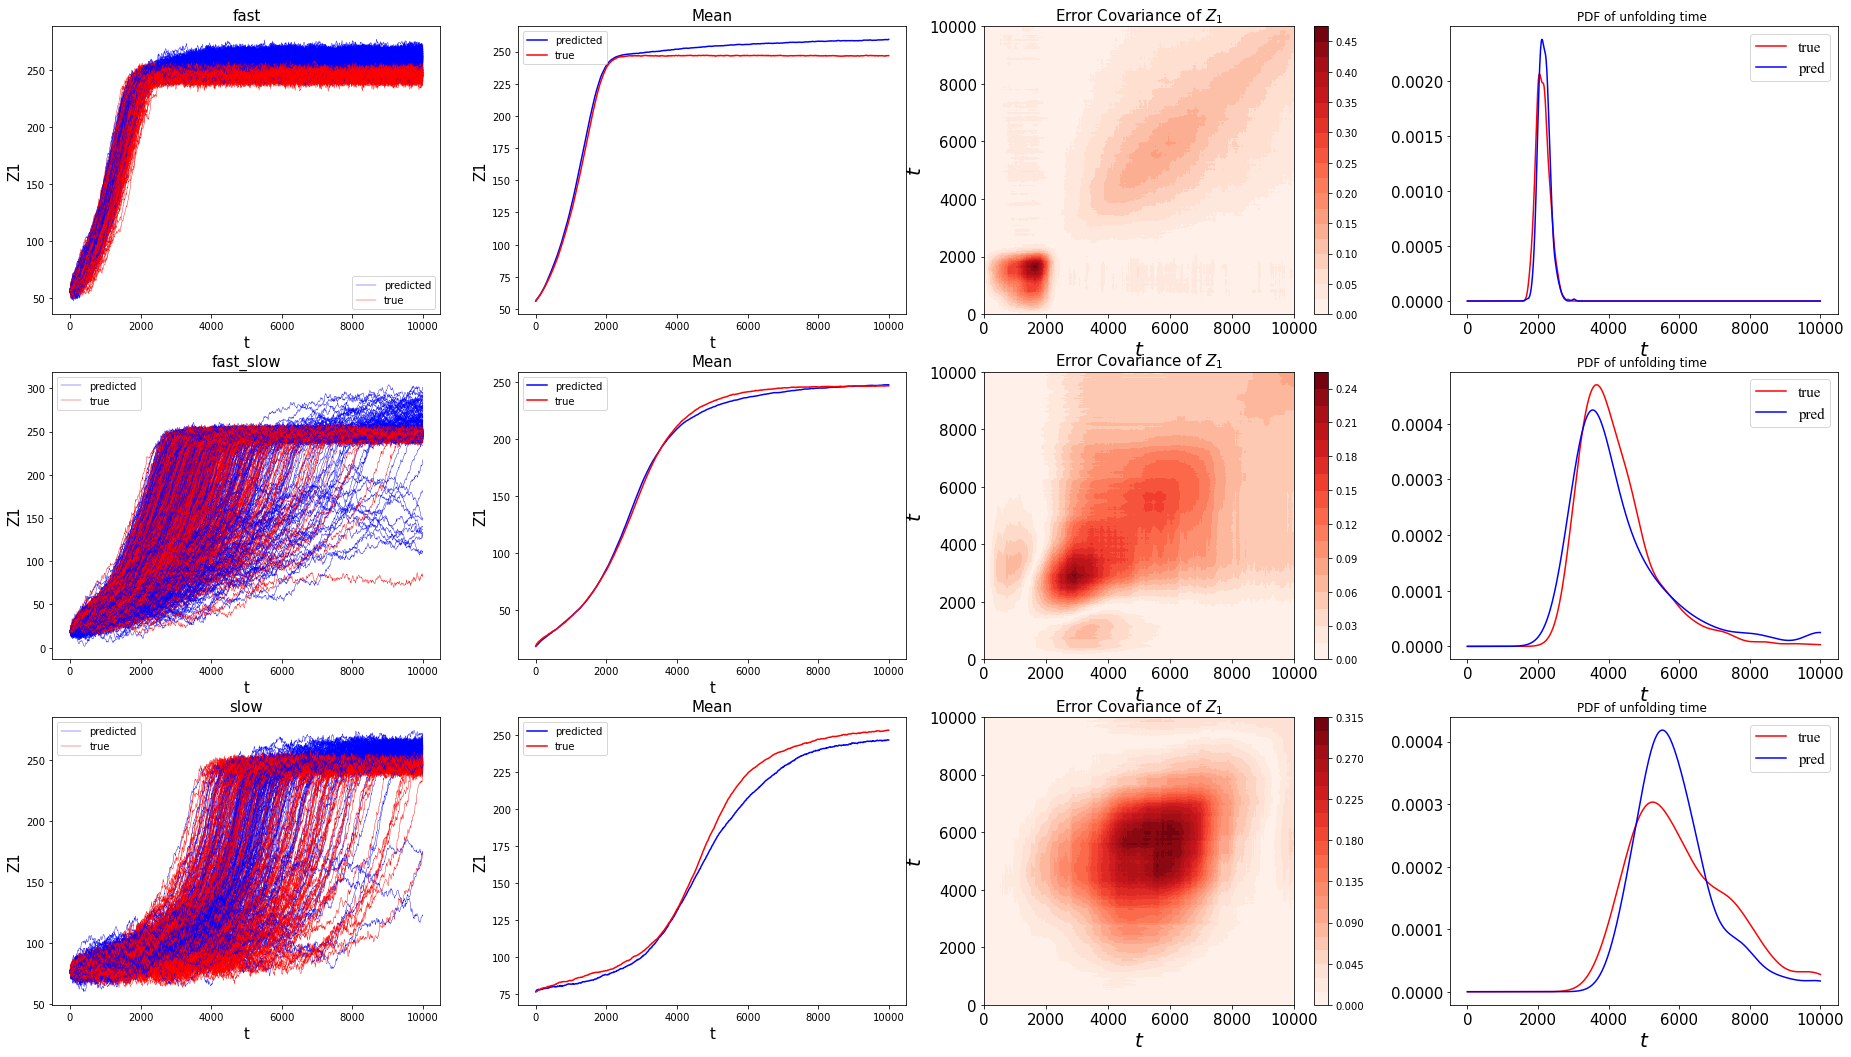

In [33]:
fig = plt.figure(figsize = (32,18))

# ------------------------------------------------------------------ #
#                             Fast                                   #
# ------------------------------------------------------------------ #
axes = fig.add_subplot(3,4,1)
for i in range(500):
    axes.plot(t,trajectory_pred_fast[i,:,0],'b',linewidth = 0.4)
    axes.plot(t,trajectory_true_fast[i,:,0],'r',linewidth = 0.4)
axes.set_xlabel('t',fontsize = 15)
axes.set_ylabel('Z1',fontsize = 15)
axes.set_title('fast',fontsize = 15)
axes.legend(['predicted','true'])

axes = fig.add_subplot(3,4,2)
axes.plot(t,pred_mean_fast[:,0],'b')
axes.plot(t,true_mean_fast[:,0],'r')
axes.legend(['predicted','true'])
axes.set_xlabel('t',fontsize = 15)
axes.set_ylabel('Z1',fontsize = 15)
axes.set_title('Mean',fontsize = 15)

axes = fig.add_subplot(3,4,3)
cov_plot(trajectory_true_fast,trajectory_pred_fast)

axes = fig.add_subplot(3,4,4)
pdf_plot(trajectory_true_fast,trajectory_pred_fast)

# ------------------------------------------------------------------ #
#                             Fast_slow                              #
# ------------------------------------------------------------------ #
axes = fig.add_subplot(3,4,5)
for i in range(500):
    axes.plot(t,trajectory_pred_fast_slow[i,:,0],'b',linewidth = 0.4)
    axes.plot(t,trajectory_true_fast_slow[i,:,0],'r',linewidth = 0.4)
axes.set_xlabel('t',fontsize = 15)
axes.set_ylabel('Z1',fontsize = 15)
axes.set_title('fast_slow',fontsize = 15)
axes.legend(['predicted','true'])

axes = fig.add_subplot(3,4,6)
axes.plot(t,pred_mean_fast_slow[:,0],'b')
axes.plot(t,true_mean_fast_slow[:,0],'r')
axes.legend(['predicted','true'])
axes.set_xlabel('t',fontsize = 15)
axes.set_ylabel('Z1',fontsize = 15)
axes.set_title('Mean',fontsize = 15)

axes = fig.add_subplot(3,4,7)
cov_plot(trajectory_true_fast_slow,trajectory_pred_fast_slow)

axes = fig.add_subplot(3,4,8)
pdf_plot(trajectory_true_fast_slow,trajectory_pred_fast_slow)

# ------------------------------------------------------------------ #
#                             Slow                                   #
# ------------------------------------------------------------------ #
axes = fig.add_subplot(3,4,9)
for i in range(200):
    axes.plot(t,trajectory_pred_slow[i,:,0],'b',linewidth = 0.4)
    axes.plot(t,trajectory_true_slow[i,:,0],'r',linewidth = 0.4)
axes.set_xlabel('t',fontsize = 15)
axes.set_ylabel('Z1',fontsize = 15)
axes.set_title('slow',fontsize = 15)
axes.legend(['predicted','true'])

axes = fig.add_subplot(3,4,10)
axes.plot(t,true_mean_slow[:,0],'b')
axes.plot(t,pred_mean_slow[:,0],'r')
axes.legend(['predicted','true'])
axes.set_xlabel('t',fontsize = 15)
axes.set_ylabel('Z1',fontsize = 15)
axes.set_title('Mean',fontsize = 15)

axes = fig.add_subplot(3,4,11)
cov_plot(trajectory_true_slow,trajectory_pred_slow)

axes = fig.add_subplot(3,4,12)
pdf_plot(trajectory_true_slow,trajectory_pred_slow)
plt.show()


In [34]:
#fig.savefig('./DNA_data/DNA_reconstruct.jpg',bbox_inches = 'tight',dpi=300)

In [35]:
#model.save_weights('./checkpoints/my_checkpoint')

In [36]:
#model.load_weights('./checkpoints/my_checkpoint')